### PART 2

#### Interesting to test and compare 3 to 4 different non linear models (maybe testing more but only 3 to 4 in the report), try to not have 3 models of the same 'family' 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance 
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

In [2]:
# Data paths
labeled_data_path = '../data/data_labeled/'
unlabeled_data_path = '../data/data_unlabeled/'

# Image paths
img_test_unlabeled_path = '../data/data_labeled/Img_test/'
img_train_unlabeled_path = '../data/data_labeled/Img_train/'
X_img_path = '../data/data_unlabeled/Img/'

# Load csv's
X_test = pd.read_csv(labeled_data_path + 'X_test.csv')
X_train = pd.read_csv(labeled_data_path + 'X_train.csv')
y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)
X_unlabeled = pd.read_csv(unlabeled_data_path + 'X.csv')

X_test.head()

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,85,106.92,2.25,120.85,14.90,7.41,3.26,resource extraction,Low,High,Moderate,36.27,93.20,heart_0.png
1,130,94.73,2.61,121.74,16.88,7.53,4.74,manufacturing,Very high,Very high,Moderate,25.97,105.24,heart_6.png
2,180,110.31,2.47,75.35,15.52,8.02,4.29,manufacturing,High,Moderate,Very low,37.53,100.61,heart_7.png
3,78,95.46,2.28,125.30,11.68,7.75,4.17,services,Very low,Low,Moderate,28.19,103.94,heart_10.png
4,116,106.13,2.11,89.98,14.83,7.89,4.73,resource extraction,Low,Very high,Low,30.07,82.53,heart_11.png


In [3]:

#Save data before cleaning
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
X_unlabeled_clean = X_unlabeled.copy()

X_train = X_train.drop(columns=['img_filename'])
X_test = X_test.drop(columns=['img_filename'])
X_unlabeled = X_unlabeled.drop(columns=['img_filename'])

X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])

# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)

'''
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
'''
#print("Train subset:", X_train.shape)
#print("Validation set:", X_val.shape)


# Standardize numerical features
numerical_features = [
    'age', 'blood pressure', 'calcium', 'cholesterol',
    'hemoglobin', 'height', 'potassium',
    'vitamin D', 'weight'
]

X_train_original = X_train.copy()
#X_val_original = X_val.copy()
X_test_original = X_test.copy()
X_unlabeled_original = X_unlabeled.copy()

'''
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])
X_unlabeled[numerical_features] = scaler.transform(X_unlabeled[numerical_features])
X_test.head()
'''


'\nscaler = StandardScaler()\nX_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])\nX_val[numerical_features] = scaler.transform(X_val[numerical_features])\nX_test[numerical_features] = scaler.transform(X_test[numerical_features])\nX_unlabeled[numerical_features] = scaler.transform(X_unlabeled[numerical_features])\nX_test.head()\n'

Utils

In [4]:

def compute_rmse(y_pred, y_true):

    y_pred, y_true = np.asarray(y_pred), np.asarray(y_true)
    mse = np.mean((y_pred - y_true) ** 2)
    return np.sqrt(mse) 


Feature Selection

In [5]:
#X_train_full = pd.concat([X_train_mrmr, X_val_mrmr], axis=0)
#y_train_full = pd.concat([y_train, y_val], axis=0)
#y_train_ravel = y_train_full.values.ravel()
mi_scores = mutual_info_regression(X_train, y_train.values.ravel(), random_state=42)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False).reset_index(drop=True)


mean_mi, std_mi = mi_df['MI'].mean(), mi_df['MI'].std()

threshold_soft = mean_mi + 0.3 * std_mi
selected_by_threshold = mi_df[mi_df['MI'] > threshold_soft]['Feature'].tolist()
print(len(selected_by_threshold))
# En cas de peu de sélection, garde toutes les features avec MI > 0
if len(selected_by_threshold) < 6:
    selected_by_threshold = mi_df[mi_df['MI'] > 0]['Feature'].tolist()

print(f"\n Seuil souple = {threshold_soft:.4f}")
print(f"{len(selected_by_threshold)} features retenues après filtrage MI :")
print(selected_by_threshold)

# Sous-ensembles correspondants
selected_features_mi = selected_by_threshold
X_train_mi = X_train[selected_features_mi].copy()
#X_val_mi   = X_val[selected_features_mi].copy()
X_test_mi  = X_test[selected_features_mi].copy()
X_unlabeled_mi = X_unlabeled[selected_features_mi].copy()

4

 Seuil souple = 0.0610
14 features retenues après filtrage MI :
['blood pressure', 'cholesterol', 'weight', 'smurfin donuts', 'potassium', 'sarsaparilla', 'vitamin D', 'profession_administration and governance', 'age', 'hemoglobin', 'profession_services', 'profession_food production', 'profession_resource extraction', 'profession_manufacturing']


MRmR

In [6]:
corr_matrix = X_train_mi.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.85)]
X_train_mrmr = X_train_mi.drop(columns=high_corr, errors='ignore')
#X_val_mrmr = X_val_mi.drop(columns=high_corr, errors='ignore')
X_test_mrmr = X_test_mi.drop(columns=high_corr, errors='ignore')
X_unlabeled_mrmr = X_unlabeled_mi.drop(columns=high_corr, errors='ignore')
y_train_ravel = y_train.values.ravel()
print(f"\n{len(high_corr)} variables redondantes supprimées après mRMR simplifié :")
print(high_corr)
print(f"{X_train_mrmr.shape[1]} features restantes après mRMR.")


0 variables redondantes supprimées après mRMR simplifié :
[]
14 features restantes après mRMR.


RF selection

In [7]:

rf_selector = RandomForestRegressor(n_estimators=100, random_state =42, n_jobs=-1)
rf_selector.fit(X_train_mrmr, y_train_ravel)

importances = rf_selector.feature_importances_
feature_names = X_train_mrmr.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 des caractéristiques selon Random Forest Importance:")
print(feature_importances_df.head(10))


Top 10 des caractéristiques selon Random Forest Importance:
                           Feature  Importance
0                   blood pressure    0.581197
9                       hemoglobin    0.117307
4                        potassium    0.098481
2                           weight    0.044934
8                              age    0.043431
1                      cholesterol    0.039196
6                        vitamin D    0.027567
5                     sarsaparilla    0.019582
3                   smurfin donuts    0.010945
12  profession_resource extraction    0.004388


Sélection de N pour le RF selector

In [9]:
rmse_scorer_for_rfecv = make_scorer(compute_rmse, greater_is_better=False)
rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...")
rfecv_selector = RFECV(
    estimator=rf_estimator,
    step=1,
    cv=5,                             # Utilise 5 plis de Cross-Validation
    scoring=rmse_scorer_for_rfecv,    # Utilisation de votre RMSE scorer
    n_jobs=-1,
    verbose=1
)
rfecv_selector.fit(X_train_mrmr, y_train_ravel)

N_optimal = rfecv_selector.n_features_
print(f"\nNombre optimal de caractéristiques (N) déterminé par CV : {N_optimal}")
selected_features_rfecv = X_train_mrmr.columns[rfecv_selector.support_].tolist()
print("\nCaractéristiques sélectionnées :")
print(selected_features_rfecv)

X_train_part2 = X_train_mrmr[selected_features_rfecv].copy()
X_test_part2 = X_test_mrmr[selected_features_rfecv].copy()

Début de la sélection de caractéristiques RFECV (Cross-Validation) en utilisant la RMSE...
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.

Nombre optimal de caractéristiques (N) déterminé par CV : 8

Caractéristiques sélectionnées :
['blood pressure', 'cholesterol', 'weight', 'potassium', 'sarsaparilla', 'vitamin D', 'age', 'hemoglobin']


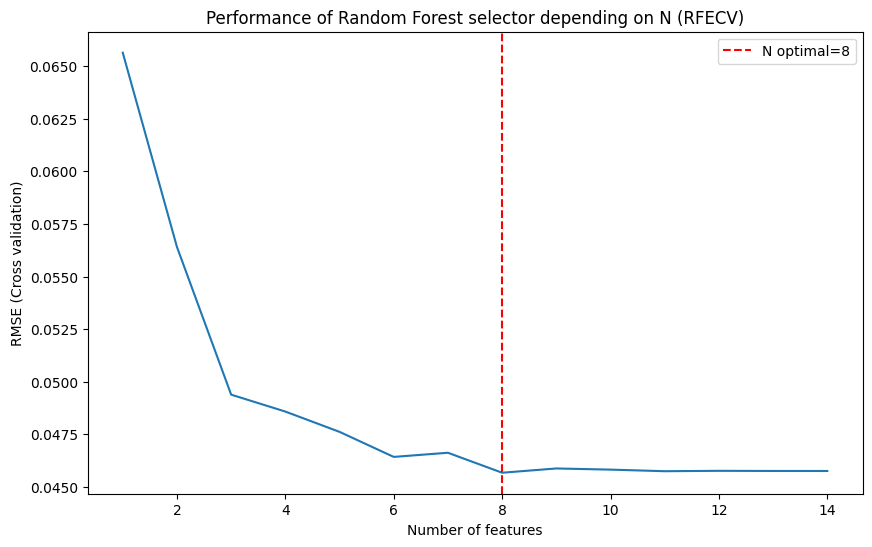

In [ ]:

# Assuming it returns the actual RMSE values (since greater_is_better=False)
scores_rmse = -rfecv_selector.cv_results_['mean_test_score'] 
n_features_range = range(1, len(X_train_mrmr.columns) + 1)

# Création du graphique (nécessite matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(n_features_range, scores_rmse)
plt.xlabel("Number of features")
plt.ylabel("RMSE (Cross validation)")
plt.title("Performance of Random Forest selector depending on N (RFECV)")
plt.axvline(x=N_optimal, color='r', linestyle='--', label=f'N optimal={N_optimal}')
plt.legend()
#plt.savefig("C:/Users/User/Desktop/GBIOM2/LELEC2870_Machine_learning/LELEC2870-Project/plots/performance_rf_selection.pdf")
plt.show()

Parameters optimization

In [20]:
print("\n--- Optimisation du Random Forest ---")
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(random_state=42)) # Uniquement le modèle
])

param_grid_rf = {
    # Nombre d'arbres : doit être suffisamment grand pour la stabilité
    'rf__n_estimators': [200, 250, 500], 
    
    # Profondeur maximale : contrôle la complexité et l'overfitting
    'rf__max_depth': [None], # None signifie illimité
    
    # Nombre de features à considérer à chaque split
    # 'sqrt' est souvent la meilleure valeur par défaut pour la régression
    'rf__max_features': [0.4,0.5,0.6]
    
    #'rf__min_samples_split' : [1,2] 
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, 
                       scoring=rmse_scorer_for_rfecv, n_jobs=-1, verbose=2)
'''rf_estimator = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_grid = GridSearchCV(
    estimator=rf_estimator,
    param_grid=param_grid_rf,
    scoring=rmse_scorer_for_rfecv,
    cv=5,
    n_jobs=-1,
    verbose=2
)'''
# Entraînement et tuning sur les 15 caractéristiques
grid_rf.fit(X_train_part2, y_train_ravel)

# Extraction du résultat RMSE réel (inversion du signe)
best_rmse_val_rf = -grid_rf.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée RF) : {best_rmse_val_rf:.4f}")
print(f"Meilleurs hyperparamètres RF : {grid_rf.best_params_}")

# Sauvegarder le meilleur modèle pour la comparaison finale
best_rf_model = grid_rf.best_estimator_


--- Optimisation du Random Forest ---
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Meilleur RMSE (Validation Croisée RF) : 0.0448
Meilleurs hyperparamètres RF : {'rf__max_depth': None, 'rf__max_features': 0.5, 'rf__n_estimators': 200}


In [13]:
print("\n--- Optimisation du K-NN ---")

pipe_knn = Pipeline([
    ('scaler', StandardScaler()), # Étape 1 : S'assure que le scaling est fait correctement
    ('knn', KNeighborsRegressor()) # Étape 2 : Le modèle k-NN
])

param_grid_knn = {
    # Nombre de voisins (k) : une valeur impaire est préférable
    'knn__n_neighbors': [5, 7, 9, 11], 
    
    # Poids : Uniforme ou Distance (les plus proches comptent plus)
    'knn__weights': ['uniform', 'distance'], 
    
    # Métrica de distance (p=1: Manhattan, p=2: Euclidienne)
    'knn__p': [1, 2] 
}
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, 
                        scoring=rmse_scorer_for_rfecv, n_jobs=-1, verbose=2)

'''knn_estimator = KNeighborsRegressor(n_jobs=-1)

knn_grid = GridSearchCV(
    estimator=knn_estimator,
    param_grid=param_grid_knn,
    scoring=rmse_scorer_for_rfecv,
    cv=5,
    n_jobs=-1,
    verbose=2
)
'''

print("\n--- Optimisation du k-Nearest Neighbors (kNN) ---")
print("Début du tuning kNN...")

# Entraînement et tuning sur les 15 caractéristiques
grid_knn.fit(X_train_part2, y_train_ravel)

# Extraction du résultat RMSE réel (inversion du signe)
best_rmse_val_knn = -grid_knn.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée kNN) : {best_rmse_val_knn:.4f}")
print(f"Meilleurs hyperparamètres kNN : {grid_knn.best_params_}")

# Sauvegarder le meilleur modèle pour la comparaison finale
best_knn_model = grid_knn.best_estimator_


--- Optimisation du K-NN ---

--- Optimisation du k-Nearest Neighbors (kNN) ---
Début du tuning kNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Meilleur RMSE (Validation Croisée kNN) : 0.0531
Meilleurs hyperparamètres kNN : {'knn__n_neighbors': 11, 'knn__p': 2, 'knn__weights': 'distance'}


In [14]:
print("\n--- Optimisation du SVR ---")
# Définir la grille d'hyperparamètres (large pour commencer, puis affiner)
pipe_svr = Pipeline([
    ('scaler', StandardScaler()), # Étape 1 : S'assure que le scaling est fait correctement
    ('svr', SVR()) # Étape 2 : Le modèle SVR
])

param_grid_svr = {
    'svr__kernel': ['rbf'], 
    'svr__C': [1, 10, 50],
    'svr__gamma': [0.001, 0.01, 0.1]
}

grid_svr= GridSearchCV(pipe_svr, param_grid_svr, cv=5, 
                        scoring=rmse_scorer_for_rfecv, n_jobs=-1, verbose=2)
'''
# Définir GridSearchCV avec votre scorer RMSE
svr_grid = GridSearchCV(
    estimator=SVR(), 
    param_grid=param_grid_svr, 
    scoring=rmse_scorer_for_rfecv, # Utilisation du même scorer RMSE
    cv=5, 
    n_jobs=-1,
    verbose=1
)
'''
print("\nDébut du tuning SVR...")

grid_svr.fit(X_train_part2, y_train_ravel)

best_rmse_val_svr = -grid_svr.best_score_ # Inverser le signe pour avoir le RMSE positif

print(f"Meilleur RMSE (Validation Croisée SVR) : {best_rmse_val_svr:.4f}")
print(f"Meilleurs hyperparamètres SVR : {grid_svr.best_params_}")
best_svr_model= grid_svr.best_estimator_


--- Optimisation du SVR ---

Début du tuning SVR...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Meilleur RMSE (Validation Croisée SVR) : 0.0517
Meilleurs hyperparamètres SVR : {'svr__C': 10, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}


In [37]:
print("\n--- Optimisation du MLP (Simple) ---")

pipe_mlp = Pipeline([
    ('scaler', StandardScaler()), # Étape 1 : S'assure que le scaling est fait correctement dans chaque pli de CV
    ('mlp', MLPRegressor(random_state=42, max_iter=2000)) # Étape 2 : Le modèle MLP
])
#'hidden_layer_sizes': [(40,20), (80, 40), (100, 60), (200, 120),(200,150), (250, 150),(300, 180),(400, 240), (600, 360)]

param_grid_mlp = {
    
    'mlp__hidden_layer_sizes': [(200, 120),(250,150)], 
    
    'mlp__activation': ['relu'],
    
    'mlp__alpha': [0.01],
    
    'mlp__learning_rate_init': [0.016], 
    
    'mlp__solver': ['adam']
}


grid_mlp = GridSearchCV(pipe_mlp, param_grid_mlp, cv=5, 
                        scoring=rmse_scorer_for_rfecv, n_jobs=-1, verbose=2)

'''
mlp_estimator = MLPRegressor(max_iter=500, random_state=42)

mlp_grid = GridSearchCV(
    estimator=mlp_estimator,
    param_grid=param_grid_mlp,
    scoring=rmse_scorer_for_rfecv, # Utilisation du scorer RMSE négatif
    cv=5,
    n_jobs=-1,
    verbose=2
)
'''

print("\n--- Optimisation du Multi-Layer Perceptron (MLP) ---")
print("Début du tuning MLP...")

# Entraînement et tuning sur les 12 caractéristiques
grid_mlp.fit(X_train_part2, y_train_ravel) 

# Extraction du résultat RMSE réel (inversion du signe)
best_rmse_val_mlp = -grid_mlp.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée MLP) : {best_rmse_val_mlp:.4f}")
print(f"Meilleurs hyperparamètres MLP : {grid_mlp.best_params_}")

# Sauvegarder le meilleur modèle pour la comparaison finale
best_mlp_model = grid_mlp.best_estimator_





--- Optimisation du MLP (Simple) ---

--- Optimisation du Multi-Layer Perceptron (MLP) ---
Début du tuning MLP...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Meilleur RMSE (Validation Croisée MLP) : 0.0423
Meilleurs hyperparamètres MLP : {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (250, 150), 'mlp__learning_rate_init': 0.016, 'mlp__solver': 'adam'}


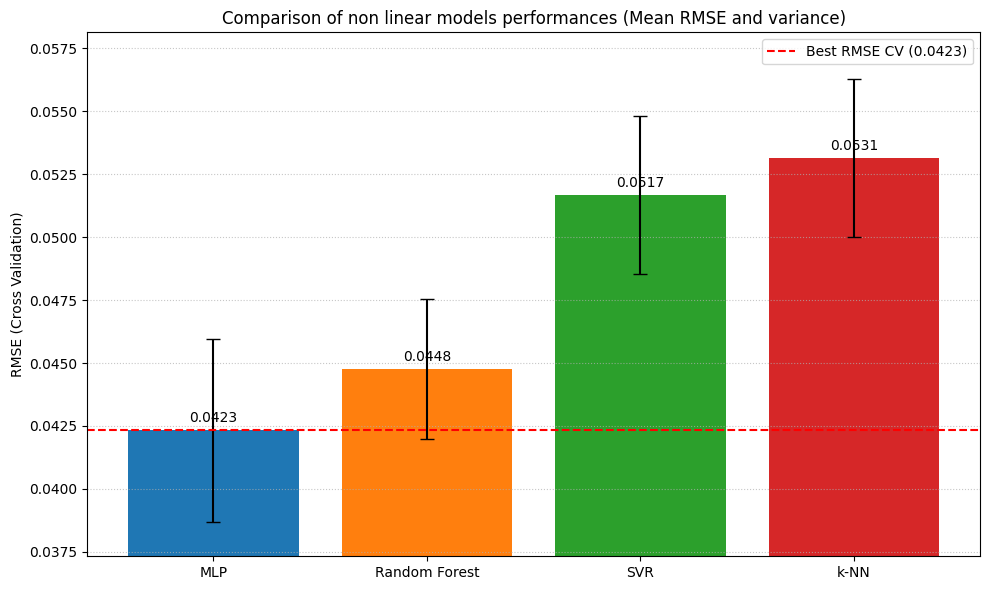

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import is_regressor
from sklearn.metrics import mean_squared_error

# --- 1. FONCTIONS D'EXTRACTION (pour la robustesse) ---

def extract_best_rmse_and_std(grid_search_object):
    """
    Extrait le meilleur RMSE (moyenne) et l'écart-type (variance) 
    du meilleur estimateur dans un objet GridSearchCV.
    """
    if grid_search_object is None:
        # Gérer le cas où un modèle n'a pas été entraîné (ex: Linéaire)
        return 0,0
    
    # Trouver l'indice de la meilleure combinaison d'hyperparamètres
    best_index = grid_search_object.best_index_
    
    # Extraire les résultats
    results = pd.DataFrame(grid_search_object.cv_results_)
    
    # Le meilleur score est négatif (rmse_scorer_for_rfecv)
    mean_rmse = -results.loc[best_index, 'mean_test_score']
    
    # L'écart-type est pour le *score* (négatif). Nous l'utilisons comme une approximation 
    # de l'écart-type du RMSE.
    std_rmse = results.loc[best_index, 'std_test_score']
    
    return mean_rmse, std_rmse


# --- 2. EXTRACTION DES DONNÉES ET DÉFINITION DE LA BASELINE ---

# Remplacer les 0.0 par vos objets de grille si vous les avez dans le contexte d'exécution
# Ici, nous utilisons les objets définis dans le code que vous avez fourni
rf_grid_obj = grid_rf
knn_grid_obj = grid_knn
svr_grid_obj = grid_svr
mlp_grid_obj = grid_mlp

#Extraction pour chaque modèle tuné
rmse_rf, std_rf = extract_best_rmse_and_std(rf_grid_obj)
rmse_knn, std_knn = extract_best_rmse_and_std(knn_grid_obj)
rmse_svr, std_svr = extract_best_rmse_and_std(svr_grid_obj)
rmse_mlp, std_mlp = extract_best_rmse_and_std(mlp_grid_obj)

# 3. Préparation des données pour le graphique
model_names = ['MLP', 'Random Forest', 'SVR', 'k-NN']
rmse_means = [rmse_mlp, rmse_rf, rmse_svr, rmse_knn]
rmse_stds = [std_mlp, std_rf, std_svr, std_knn] # Std très petite pour la baseline (estimation)

# 4. Couleurs pour les barres (pour la lisibilité)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#808080'] # Bleu, Orange, Vert, Rouge, Gris
best_rmse_cv = min(rmse_means)


# --- 3. TRACÉ DU GRAPHIQUE ---

plt.figure(figsize=(10, 6))

# Créer le graphique en barres avec des barres d'erreur
bars = plt.bar(model_names, rmse_means, yerr=rmse_stds, capsize=5, color=colors)

# Ajouter des annotations de valeur au-dessus des barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0002, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

# Ajouter une ligne pour le niveau de référence
plt.axhline(y=best_rmse_cv, color='r', linestyle='--', label=f'Best RMSE CV ({best_rmse_cv:.4f})')

plt.ylim(min(rmse_means) - 0.005, max(rmse_means) + 0.005) # Ajuster l'axe Y pour mettre en évidence les différences
plt.ylabel("RMSE (Cross Validation)")
plt.title("Comparison of non linear models performances (Mean RMSE and variance)")
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.savefig("C:/Users/User/Desktop/GBIOM2/LELEC2870_Machine_learning/LELEC2870-Project/plots/final_model_comparison_cv.pdf")
plt.show()


--- Optimisation du MLP (Simple) ---

--- Optimisation du Multi-Layer Perceptron (MLP) ---
Début du tuning MLP...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Meilleur RMSE (Validation Croisée MLP) : 0.0418
Meilleurs hyperparamètres MLP : {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (200, 150), 'mlp__learning_rate_init': 0.016, 'mlp__solver': 'adam'}


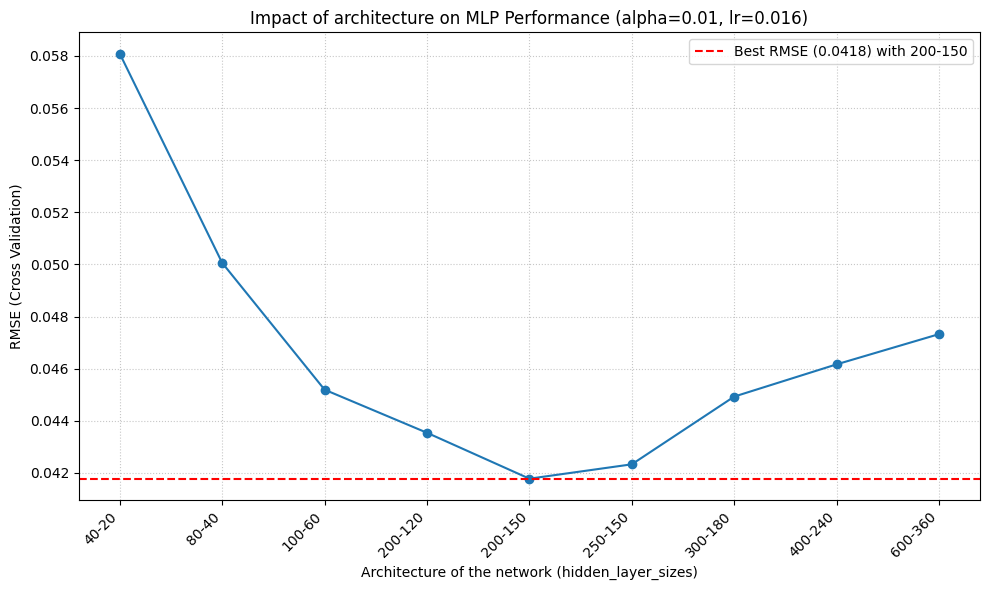

In [42]:
print("\n--- Optimisation du MLP (Simple) ---")

mlp_base_estimator = MLPRegressor(max_iter=500, random_state=42)

# Créer le Pipeline : Scaling puis MLP
pipe_mlp_fine_tune = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', mlp_base_estimator) 
])
param_grid_mlp_final = {
    # Architectures à tester :
    # Essayer des configurations à 1 ou 2 couches
    # (40,) : 1 couche de 40 neurones (assez petite pour 12 features)
    # (40, 20) : 2 couches (40 puis 20)
    # (80, 40) : 2 couches plus larges
    'mlp__hidden_layer_sizes': [(40,20), (80, 40), (100, 60), (200, 120),(200,150), (250, 150),(300, 180),(400, 240), (600, 360)], 
    
    # Fonction d'activation (ReLU est standard et performante)
    'mlp__activation': ['relu'],
    
    # Terme de régularisation L2 (alpha)
    # Le MLP est sensible à l'overfitting, donc il faut tester la régularisation
    'mlp__alpha': [0.01],
    
    # Taux d'apprentissage initial
    'mlp__learning_rate_init': [0.016], 
    
    'mlp__solver': ['adam']
}
#Meilleurs hyperparamètres MLP : {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (400, 240), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
# Fixer le nombre maximum d'itérations
# max_iter doit être suffisant pour que le réseau converge (souvent 500 ou 1000)
#mlp_estimator_final = MLPRegressor(max_iter=500, random_state=42)

mlp_grid_final = GridSearchCV(
    estimator=pipe_mlp_fine_tune,
    param_grid=param_grid_mlp_final,
    scoring=rmse_scorer_for_rfecv, # Utilisation du scorer RMSE négatif
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\n--- Optimisation du Multi-Layer Perceptron (MLP) ---")
print("Début du tuning MLP...")

# Entraînement et tuning sur les 12 caractéristiques
mlp_grid_final.fit(X_train_part2, y_train_ravel) 

# Extraction du résultat RMSE réel (inversion du signe)
best_rmse_val_mlp_final = -mlp_grid_final.best_score_ 

print(f"\nMeilleur RMSE (Validation Croisée MLP) : {best_rmse_val_mlp_final:.4f}")
print(f"Meilleurs hyperparamètres MLP : {mlp_grid_final.best_params_}")

# Sauvegarder le meilleur modèle pour la comparaison finale
best_mlp_model_final = mlp_grid_final.best_estimator_


import pandas as pd


# Assurez-vous d'utiliser l'objet mlp_grid après le fit final
results = pd.DataFrame(mlp_grid_final.cv_results_)

# Création d'une clé d'architecture simple pour le graphique
# Nous allons simplifier l'affichage du tuple (ex: (80, 40) devient '80-40')
def format_architecture(hls_tuple):
    if isinstance(hls_tuple, tuple):
        return '-'.join(map(str, hls_tuple))
    return str(hls_tuple)

results['Architecture_str'] = results['param_mlp__hidden_layer_sizes'].apply(format_architecture)

# Filtrer uniquement les résultats avec les meilleurs autres hyperparamètres 
# (activation='relu', alpha=0.015, learning_rate_init=0.015, solver='adam') 
# pour isoler l'effet de la taille des couches.

best_alpha = mlp_grid_final.best_params_['mlp__alpha']
best_lr = mlp_grid_final.best_params_['mlp__learning_rate_init']

filtered_results = results[
    (results['param_mlp__alpha'] == best_alpha) & 
    (results['param_mlp__learning_rate_init'] == best_lr) &
    (results['param_mlp__activation'] == 'relu') # Si vous n'avez testé que 'relu'
].copy()

# Calcul du RMSE réel (inverser le signe du score CV)
results['RMSE_CV'] = -results['mean_test_score']
plt.figure(figsize=(10, 6))

# Création du graphique : Architecture (X) vs RMSE (Y)
plt.plot(
    results['Architecture_str'], 
    results['RMSE_CV'], 
    marker='o', 
    linestyle='-', 
    color='#1f77b4'
)

# Marquage du meilleur score
min_rmse = results['RMSE_CV'].min()
best_arch = results.loc[results['RMSE_CV'].idxmin(), 'Architecture_str']
plt.axhline(y=min_rmse, color='r', linestyle='--', 
            label=f'Best RMSE ({min_rmse:.4f}) with {best_arch}')

plt.xlabel("Architecture of the network (hidden_layer_sizes)")
plt.ylabel("RMSE (Cross Validation)")
plt.title(f"Impact of architecture on MLP Performance (alpha={best_alpha}, lr={best_lr})")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("C:/Users/User/Desktop/GBIOM2/LELEC2870_Machine_learning/LELEC2870-Project/plots/MLP_performance.pdf")
plt.show()


Le meilleur modèle non linéaire global est: MLP
Meilleur RMSE de Validation Croisée: 0.0418

--- Importance par Permutation pour le meilleur modèle: MLP ---

--- Top 12 Caractéristiques par Importance de Permutation ---
          Feature  Importance_Mean  Importance_Std
0  blood pressure        -0.579684        0.039424
1      hemoglobin        -0.156021        0.020428
2       potassium        -0.144266        0.014654
3          weight        -0.061434        0.009943
4             age        -0.045694        0.008182
5    sarsaparilla        -0.044729        0.008405
6     cholesterol        -0.024030        0.009989
7       vitamin D        -0.002051        0.004306


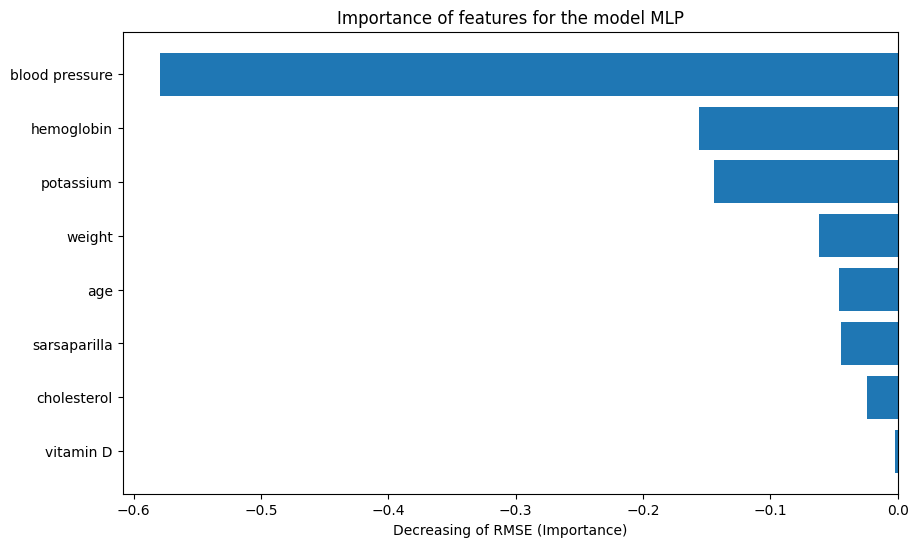

In [39]:
# Rassembler les résultats des meilleurs modèles

results = {
    "Random Forest": {'model': best_rf_model, 'rmse': best_rmse_val_rf},
    "K-NN": {'model': best_knn_model, 'rmse': best_rmse_val_knn},
    "SVR": {'model': best_svr_model, 'rmse': best_rmse_val_svr},
    "MLP": {'model': best_mlp_model_final, 'rmse': best_rmse_val_mlp_final},
}

# Trouver le meilleur modèle
best_model_name = min(results, key=lambda k: results[k]['rmse'])
best_model = results[best_model_name]['model']
best_rmse_cv_ = results[best_model_name]['rmse']

print(f"\n=======================================================")
print(f"Le meilleur modèle non linéaire global est: {best_model_name}")
print(f"Meilleur RMSE de Validation Croisée: {best_rmse_cv_:.4f}")
print(f"=======================================================")

# --- ANALYSE D'IMPORTANCE PAR PERMUTATION ---
# Appliquée au meilleur modèle global
print(f"\n--- Importance par Permutation pour le meilleur modèle: {best_model_name} ---")

y_test_ravel = y_test.values.ravel() if hasattr(y_test, 'values') else y_test.ravel()
result = permutation_importance(
    best_model, 
    X_test_part2, 
    y_test_ravel, 
    n_repeats=50, # Augmenter les répétitions pour plus de stabilité
    random_state=42, 
    n_jobs=-1
)

# Créer un DataFrame pour la visualisation
feature_names_list = X_test_part2.columns
sorted_idx = result.importances_mean.argsort()[::-1]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_list[sorted_idx],
    'Importance_Mean': -result.importances_mean[sorted_idx],
    'Importance_Std': result.importances_std[sorted_idx]
})

print("\n--- Top 12 Caractéristiques par Importance de Permutation ---")
print(feature_importance_df)
#Optionnel : Afficher le graphique de l'importance (non requis, mais très utile)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance_Mean'])
plt.xlabel("Decreasing of RMSE (Importance)")
plt.title(f"Importance of features for the model {best_model_name}")
plt.gca().invert_yaxis()
plt.show()


  TABLEAU FINAL DES PERFORMANCES SUR L'ENSEMBLE DE TEST  
MLP                  : 0.0428
Random Forest        : 0.0464
SVR                  : 0.0486
K-NN                 : 0.0521
Linéaire (Baseline)  : 0.0558
Le meilleur score de généralisation final est : 0.0428


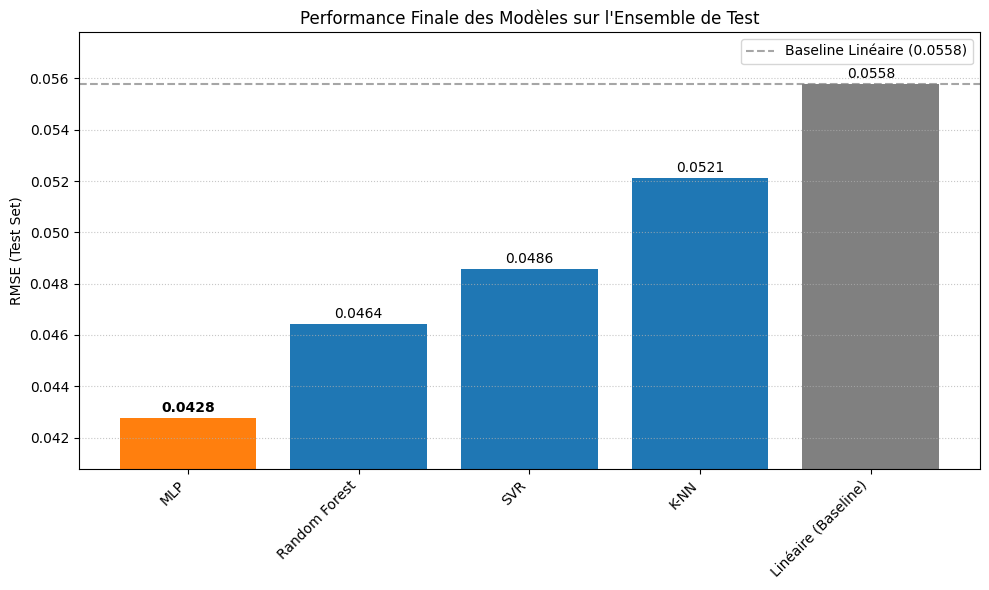

In [41]:


# --- 2. Prédictions et Calculs ---

# Assurez-vous que X_test_part2 (12 features) et y_test_ravel sont définis

# Prédictions sur l'ensemble de Test
y_pred_test_mlp = best_mlp_model_final.predict(X_test_part2)
y_pred_test_rf = best_rf_model.predict(X_test_part2)
y_pred_test_svr = best_svr_model.predict(X_test_part2)
y_pred_test_knn = best_knn_model.predict(X_test_part2)

# Calcul des RMSE de Test
rmse_test_mlp = compute_rmse(y_pred_test_mlp, y_test_ravel)
rmse_test_rf = compute_rmse(y_pred_test_rf, y_test_ravel)
rmse_test_svr = compute_rmse(y_pred_test_svr, y_test_ravel)
rmse_test_knn = compute_rmse(y_pred_test_knn, y_test_ravel)

# Modèle Linéaire (Baseline - Valeur obtenue en Partie 1)
rmse_test_linear = 0.0558 

# --- 3. Synthèse des Résultats Finals ---

results_test = {
    "MLP": rmse_test_mlp,
    "Random Forest": rmse_test_rf,
    "SVR": rmse_test_svr,
    "K-NN": rmse_test_knn,
    "Linéaire (Baseline)": rmse_test_linear
}

print("\n=======================================================")
print("  TABLEAU FINAL DES PERFORMANCES SUR L'ENSEMBLE DE TEST  ")
print("=======================================================")
# Affichage trié par ordre croissant de RMSE (meilleure performance en premier)
for model, rmse in sorted(results_test.items(), key=lambda item: item[1]):
    print(f"{model:<20} : {rmse:.4f}")
print("=======================================================")

best_final_rmse = min(results_test.values())
print(f"Le meilleur score de généralisation final est : {best_final_rmse:.4f}")

results_test = {
    "MLP": rmse_test_mlp,
    "Random Forest": rmse_test_rf,
    "SVR": rmse_test_svr,
    "K-NN": rmse_test_knn,
    "Linéaire (Baseline)": rmse_test_linear
}

# Tri des modèles par RMSE (du meilleur au moins bon)
sorted_results = dict(sorted(results_test.items(), key=lambda item: item[1]))
model_names = list(sorted_results.keys())
rmse_values = list(sorted_results.values())

# 2. TRACÉ DU GRAPHIQUE

plt.figure(figsize=(10, 6))

# Couleurs (pour distinguer le vainqueur et la baseline)
colors = ['#1f77b4'] * 4 + ['#808080'] # MLP/RF/SVR/kNN en bleu, Linéaire en gris
# Mettre le vainqueur en évidence (la première barre après le tri)
colors[0] = '#ff7f0e' # Orange pour le meilleur modèle (MLP)

bars = plt.bar(model_names, rmse_values, color=colors)

# Ajouter des annotations de valeur au-dessus des barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0001, f'{yval:.4f}', ha='center', va='bottom', fontsize=10, weight='bold' if yval == min(rmse_values) else 'normal')

# Ajouter une ligne pour la baseline Linéaire
plt.axhline(y=rmse_test_linear, color='gray', linestyle='--', label=f'Baseline Linéaire ({rmse_test_linear:.4f})', alpha=0.7)


plt.ylim(min(rmse_values) - 0.002, max(rmse_values) + 0.002) # Ajuster l'axe Y
plt.ylabel("RMSE (Test Set)")
plt.title("Performance Finale des Modèles sur l'Ensemble de Test")
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("C:/Users/User/Desktop/GBIOM2/LELEC2870_Machine_learning/LELEC2870-Project/plots/comparaison_test_finale.pdf")
plt.show()